### Welcome to the exercise about observational studies! This exercise will be hands on, and you will be able to practise the skills you developed so far!

## Propensity score matching

In this exercise, you will apply [propensity score matching](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf), which we discussed in lecture 6 ("Observational studies"), in order to draw conclusions from an observational study.

We will work with a by-now classic dataset from Robert LaLonde's study "[Evaluating the Econometric Evaluations of Training Programs](http://people.hbs.edu/nashraf/LaLonde_1986.pdf)" (1986).
The study investigated the effect of a job training program ("National Supported Work Demonstration") on the real earnings of an individual, a couple of years after completion of the program.
Your task is to determine the effectiveness of the "treatment" represented by the job training program.

#### Dataset description

- `treat`: 1 if the subject participated in the job training program, 0 otherwise
- `age`: the subject's age
- `educ`: years of education
- `race`: categorical variable with three possible values: Black, Hispanic, or White
- `married`: 1 if the subject was married at the time of the training program, 0 otherwise
- `nodegree`: 1 if the subject has earned no school degree, 0 otherwise
- `re74`: real earnings in 1974 (pre-treatment)
- `re75`: real earnings in 1975 (pre-treatment)
- `re78`: real earnings in 1978 (outcome)

If you want to deepen your knowledge on propensity scores and observational studies, we highly recommend Rosenbaum's excellent book on the ["Design of Observational Studies"](http://www.stewartschultz.com/statistics/books/Design%20of%20observational%20studies.pdf). Even just reading the first chapter (18 pages) will help you a lot.

In [1]:
import pandas as pd
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
%matplotlib inline

data_folder = './data/'
df = pd.read_csv(data_folder + 'lalonde.csv')

In [2]:
df.sample(10)

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78
434,PSID250,0,32,13,0,0,1,0,12553.0200,524.5645,15353.5800
393,PSID209,0,16,10,0,0,0,1,574.0652,1181.6130,5578.4180
174,NSW175,1,26,10,1,0,0,1,25929.6800,6788.9580,672.8773
331,PSID147,0,37,14,0,0,1,0,18501.3600,2638.9350,13429.5800
522,PSID338,0,26,5,0,0,1,1,1573.2910,0.0000,3700.2270
93,NSW94,1,21,12,1,0,0,0,0.0000,0.0000,9983.7840
557,PSID373,0,20,12,1,0,0,0,0.0000,0.0000,0.0000
110,NSW111,1,20,9,1,0,0,1,6083.9940,0.0000,8881.6650
470,PSID286,0,49,8,0,0,1,1,14684.7000,136.0645,14963.4600
584,PSID400,0,37,8,1,0,0,1,0.0000,0.0000,648.7220


## 1. A naive analysis

Compare the distribution of the outcome variable (`re78`) between the two groups, using plots and numbers.
To summarize and compare the distributions, you may use the techniques we discussed in lecture 4 ("Descibing data") and 3 ("Visualizing data").

What might a naive "researcher" conclude from this superficial analysis?

normal dist test (0.18160652733820204, 0.0009999999999998899)
exponential dist test (0.23289902280130292, 0.0009999999999998899)
Both values have very small p-values, so the hypotheses that they come from that specific distribution can be rejected at a 0.001 significance level
count      614.000000
mean      6792.834483
std       7470.730792
min          0.000000
25%        238.283425
50%       4759.018500
75%      10893.592500
max      60307.930000
Name: re78, dtype: float64
Boxplot shows that there are some outliers at the maximum
Histogram shows that most units come from the first bin


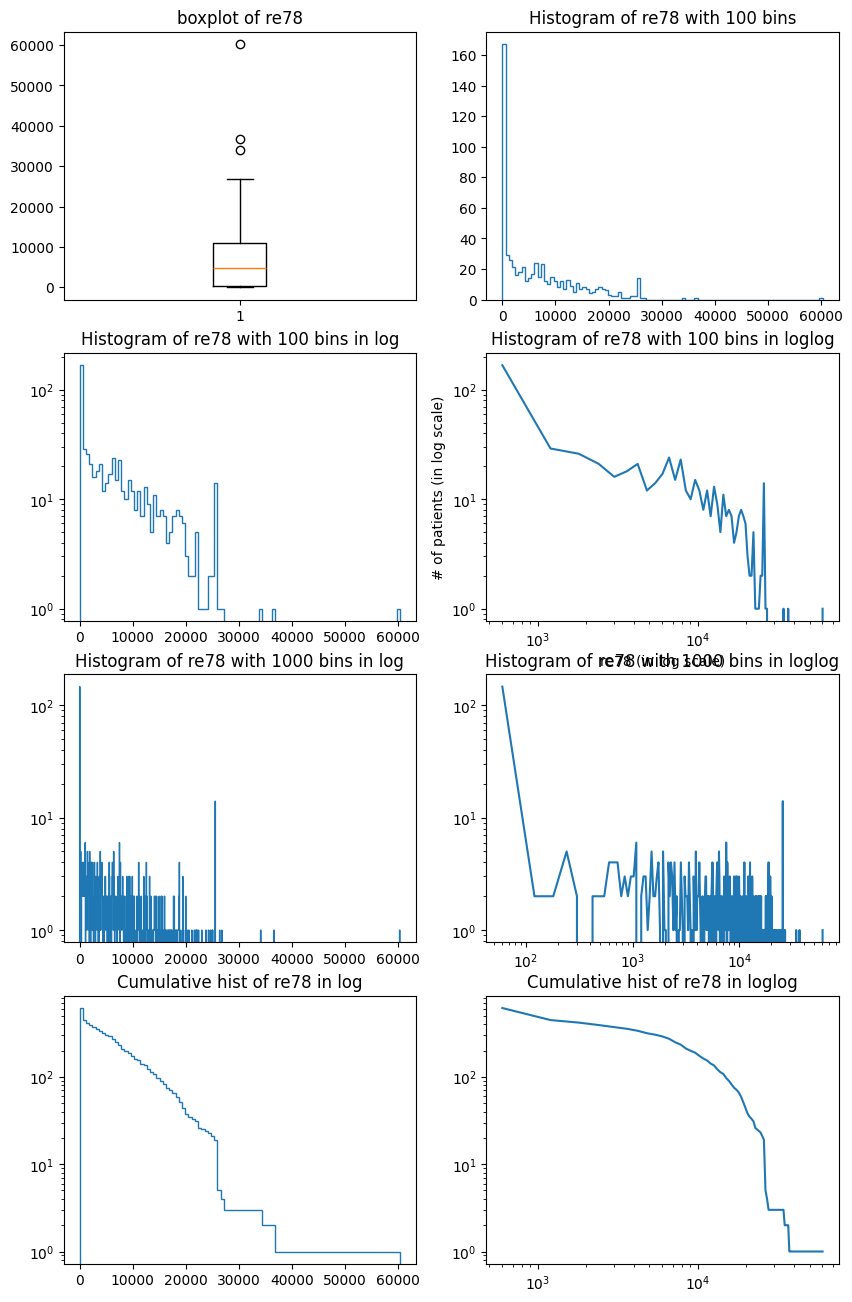

In [3]:
''' your code and explanations ''';

data = df['re78']

# 1. test distributions
from statsmodels.stats import diagnostic
print('normal dist test', diagnostic.kstest_normal(data))
print('exponential dist test', diagnostic.kstest_exponential(data))

print("Both values have very small p-values, so the hypotheses that they come \
from that specific distribution can be rejected at a 0.001 significance level")

# 2. describe data
print(data.describe())

# 3. visualize data
plt.figure(figsize=(10, 16))
plt.tight_layout(pad=10.0)
plt.subplot(4, 2, 1)
plt.boxplot(data)
plt.title('boxplot of re78')
print('Boxplot shows that there are some outliers at the maximum')

plt.subplot(4,2,2)
plt.hist(data, bins=100, histtype='step')
plt.title('Histogram of re78 with 100 bins')
print('Histogram shows that most units come from the first bin')

plt.subplot(4,2,3)
log_plot = plt.hist(data, log=True, bins=100, histtype='step')
plt.title('Histogram of re78 with 100 bins in log')

plt.subplot(4,2,4)
plt.loglog(log_plot[1][1:],log_plot[0])
plt.title('Histogram of re78 with 100 bins in loglog')
plt.ylabel('# of patients (in log scale)')
plt.xlabel('re78 (in log scale)')

plt.subplot(4,2,5)
log_1000 = plt.hist(data,bins=1000,log=True,histtype='step')
plt.title('Histogram of re78 with 1000 bins in log')

plt.subplot(4,2,6)
plt.loglog(log_1000[1][1:], log_1000[0])
plt.title('Histogram of re78 with 1000 bins in loglog')

plt.subplot(4,2,7)
log_cumul = plt.hist(data, bins=100, log=True, cumulative=-1, histtype='step')
plt.title('Cumulative hist of re78 in log')

plt.subplot(4,2,8)
plt.loglog(log_cumul[1][1:], log_cumul[0])
plt.title('Cumulative hist of re78 in loglog')
plt.show()

## 2. A closer look at the data

You're not naive, of course (and even if you are, you've learned certain things in ADA), so you aren't content with a superficial analysis such as the above.
You're aware of the dangers of observational studies, so you take a closer look at the data before jumping to conclusions.

For each feature in the dataset, compare its distribution in the treated group with its distribution in the control group, using plots and numbers.
As above, you may use the techniques we discussed in class for summarizing and comparing the distributions.

What do you observe?
Describe what your observations mean for the conclusions drawn by the naive "researcher" from his superficial analysis.

In [4]:
''' your code and explanations ''';
treat=df.loc[df['treat']==1]
contr=df.loc[df['treat']==0]


# sns.pairplot(df)


In [5]:
# sns.pairplot(treat)

In [6]:
# sns.pairplot(contr)

(2, 3)
       white  black  hispan
treat                      
0        281     87      61
1         18    156      11


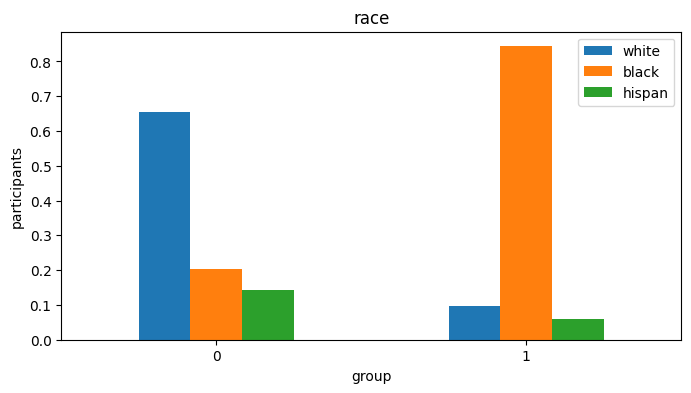

In [7]:
''' your code and explanations ''';

# race

df['white'] = (~(df['black'].astype(bool) \
                    | df['hispan'].astype(bool))).astype(bool)

df_group = df.groupby(df.treat)[['white', 'black', 'hispan']].sum()
# df_group.reset_index(inplace=True)
print(df_group.shape)
print(df_group.head())
df_group = df_group.div(df_group.sum(axis=1), axis=0)
pl = df_group.plot(kind='bar', figsize=[8,4], rot=0)
pl.set_title('race')
pl.set_ylabel('participants')
pl.set_xlabel('group')
plt.show()

# white outnumber the other races in the control group, and on the 
# other hand, in the treated group the proportion of black is almost 
# the only one

## 3. A propensity score model

Use logistic regression to estimate propensity scores for all points in the dataset.
You may use `statsmodels` to fit the logistic regression model and apply it to each data point to obtain propensity scores.

Recall that the propensity score of a data point represents its probability of receiving the treatment, based on its pre-treatment features (in this case, age, education, pre-treatment income, etc.).
To brush up on propensity scores, you may read chapter 3.3 of the above-cited book by Rosenbaum or [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).

Note: you do not need a train/test split here. Train and apply the model on the entire dataset. If you're wondering why this is the right thing to do in this situation, recall that the propensity score model is not used in order to make predictions about unseen data. Its sole purpose is to balance the dataset across treatment groups.
(See p. 74 of Rosenbaum's book for an explanation why slight overfitting is even good for propensity scores.
If you want even more information, read [this article](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC3144483/pdf/hmbr46-399.pdf).)

In [8]:
''' your code and explanations ''';

import statsmodels.formula.api as smf
from scipy.stats import zscore

non_categorical = ['age', 'educ', 're74', 're75']
normalized_df = df.copy()

for col in non_categorical:
  normalized_df[col] = zscore(normalized_df[col])

normalized_df.head()


,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white
0,NSW1,1,0.976063,0.278454,1,0,1,1,-0.70412,-0.663511,9930.0460,False
1,NSW2,1,-0.543211,-0.483108,0,1,0,1,-0.70412,-0.663511,3595.8940,False
2,NSW3,1,0.267069,0.659234,1,0,0,0,-0.70412,-0.663511,24909.4500,False
3,NSW4,1,-0.036786,0.278454,1,0,0,1,-0.70412,-0.663511,7506.1460,False
4,NSW5,1,0.570924,-0.863888,1,0,0,1,-0.70412,-0.663511,289.7899,False


In [9]:
model = smf.logit(formula='treat ~ + age + educ + C(black) + C(hispan) + \
                  C(married) + C(nodegree) + re74 + re75', data=normalized_df)
fitted_model = model.fit()
propensity_score = fitted_model.predict()
normalized_df['Propensity Score'] = propensity_score
print(fitted_model.summary())

Optimization terminated successfully.
         Current function value: 0.397267
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:                  treat   No. Observations:                  614
Model:                          Logit   Df Residuals:                      605
Method:                           MLE   Df Model:                            8
Date:                Wed, 13 Nov 2024   Pseudo R-squ.:                  0.3508
Time:                        06:05:18   Log-Likelihood:                -243.92
converged:                       True   LL-Null:                       -375.75
Covariance Type:            nonrobust   LLR p-value:                 2.194e-52
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
Intercept           -2.8509      0.350     -8.147      0.000      -3.537      -2.165
C(black)[T.

## 4. Balancing the dataset via matching

Use the propensity scores to match each data point from the treated group with exactly one data point from the control group, while ensuring that each data point from the control group is matched with at most one data point from the treated group.
(Hint: you may explore the `networkx` package in Python for predefined matching functions.)

Your matching should maximize the similarity between matched subjects, as captured by their propensity scores.
In other words, the sum (over all matched pairs) of absolute propensity-score differences between the two matched subjects should be minimized.

This is how networkx library can help you do this. Each possible pair of (treated_person, control_person) is characterized by a similarity. This is how we can initialize a graph, and add an edge for one possible pair. We then need to add an edge for each possible pair.
    - G = nx.Graph()
    - G.add_weighted_edges_from([(control_person, treated_person, similarity)])
Optimal matching is then found with:
    - matching = nx.max_weight_matching(G)

After matching, you have as many treated as you have control subjects.
Compare the outcomes (`re78`) between the two groups (treated and control).

Also, compare again the feature-value distributions between the two groups, as you've done in part 2 above, but now only for the matched subjects.
What do you observe?
Are you closer to being able to draw valid conclusions now than you were before?

In [10]:
''' your code and explanations ''';
import networkx as nx

def pair_similarity(a,b):
  return 1 - abs(a - b)

treat = normalized_df[normalized_df['treat'] == 1]
contr = normalized_df[normalized_df['treat'] == 0]

G = nx.Graph()

for i in treat.index:
  for j in contr.index:
    # print(treat['Propensity Score'][i], contr['Propensity Score'][j])
    similarity = pair_similarity(treat['Propensity Score'][i], contr['Propensity Score'][j])
    G.add_weighted_edges_from([(i, j, similarity)])

matching = nx.max_weight_matching(G)

In [11]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]
print(matching)
print(matched)

balanced_df_1 = normalized_df.iloc[matched]

balanced_df_1

{(12, 425), (128, 563), (56, 437), (69, 367), (3, 376), (302, 7), (281, 73), (112, 603), (529, 89), (525, 171), (130, 444), (33, 557), (139, 355), (125, 283), (294, 30), (324, 65), (230, 177), (192, 147), (169, 392), (0, 535), (21, 393), (119, 391), (571, 152), (411, 163), (10, 484), (366, 149), (600, 87), (584, 70), (423, 180), (91, 576), (232, 48), (140, 386), (58, 225), (450, 118), (278, 109), (39, 556), (322, 88), (368, 158), (280, 164), (60, 560), (24, 595), (27, 383), (144, 456), (528, 9), (34, 334), (37, 513), (145, 320), (161, 609), (549, 178), (344, 166), (17, 592), (521, 116), (45, 608), (293, 136), (38, 569), (176, 466), (47, 370), (160, 546), (540, 141), (104, 596), (552, 5), (14, 458), (31, 474), (590, 62), (243, 61), (570, 93), (96, 341), (282, 138), (568, 59), (159, 452), (99, 465), (410, 131), (588, 92), (554, 78), (515, 25), (519, 175), (538, 155), (77, 455), (601, 28), (2, 440), (449, 150), (208, 72), (211, 153), (583, 98), (448, 53), (510, 4), (363, 113), (217, 123),

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,Propensity Score
12,NSW13,1,-0.948350,-0.863888,1,0,0,1,-0.704120,-0.663511,0.0000,False,0.649868
128,NSW129,1,-0.441926,0.659234,0,1,0,0,0.745933,-0.324173,559.4432,False,0.113004
56,NSW57,1,0.976063,-0.483108,1,0,0,1,-0.704120,-0.663511,1067.5060,False,0.746405
69,NSW70,1,0.165784,1.040015,1,0,0,0,-0.704120,-0.663511,7479.6560,False,0.709147
3,NSW4,1,-0.036786,0.278454,1,0,0,1,-0.704120,-0.663511,7506.1460,False,0.776324
...,...,...,...,...,...,...,...,...,...,...,...,...,...
105,NSW106,1,1.583773,-0.483108,1,0,0,1,-0.704120,-0.663511,0.0000,False,0.763902
442,PSID258,0,-0.948350,-0.102327,0,0,0,1,-0.704120,-0.546077,0.0000,True,0.108745
51,NSW52,1,0.368354,0.278454,1,0,1,1,-0.704120,-0.663511,8087.4870,False,0.616653
585,PSID401,0,-1.049635,-0.102327,1,0,0,1,-0.704120,-0.663511,1053.6190,False,0.716120


In [14]:
index1 = 0
index2 = (len(matched) // 2)
while index2 < len(matched):
  if abs(balanced_df_1["Propensity Score"][matched[index1]] - balanced_df_1["Propensity Score"][matched[index2]]) > 0.2:
    print(matched[index1], matched[index2], balanced_df_1["Propensity Score"][matched[index1]], balanced_df_1["Propensity Score"][matched[index2]])
    print(balanced_df_1.loc[matched[index1]])
    print(balanced_df_1.loc[matched[index2]])

  index1+=1
  index2+=1


12 425 0.6498676682147799 0.18367205539011694
id                     NSW13
treat                      1
age                 -0.94835
educ               -0.863888
black                      1
hispan                     0
married                    0
nodegree                   1
re74                -0.70412
re75               -0.663511
re78                     0.0
white                  False
Propensity Score    0.649868
Name: 12, dtype: object
id                   PSID241
treat                      0
age                 -0.94835
educ                0.659234
black                      0
hispan                     1
married                    0
nodegree                   0
re74                -0.70412
re75               -0.472137
re78                4843.988
white                  False
Propensity Score    0.183672
Name: 425, dtype: object
69 367 0.7091465902125963 0.10916183424501068
id                     NSW70
treat                      1
age                 0.165784
educ              

## 5. Balancing the groups further

Based on your comparison of feature-value distributions from part 4, are you fully satisfied with your matching?
Would you say your dataset is sufficiently balanced?
If not, in what ways could the "balanced" dataset you have obtained still not allow you to draw valid conclusions?

Improve your matching by explicitly making sure that you match only subjects that have the same value for the problematic feature.
Argue with numbers and plots that the two groups (treated and control) are now better balanced than after part 4.


In [13]:
''' your code and explanations ''';

treatment_df = normalized_df[normalized_df['treat'] == 1]
control_df = normalized_df[normalized_df['treat'] == 0]


G = nx.Graph()

for control_id, control_row in control_df.iterrows():
    for treatment_id, treatment_row in treatment_df.iterrows():

        # Adds an edge only if the individuals have the same race
        if (control_row['black'] == treatment_row['black'])\
            and (control_row['hispan'] == treatment_row['hispan']):
            similarity = pair_similarity(control_row['Propensity Score'],
                                        treatment_row['Propensity Score'])

            G.add_weighted_edges_from([(control_id, treatment_id, similarity)])

matching = nx.max_weight_matching(G)


In [14]:
matched = [i[0] for i in list(matching)] + [i[1] for i in list(matching)]

balanced_df_all = normalized_df.iloc[matched]
balanced_df_all

,id,treat,age,educ,black,hispan,married,nodegree,re74,re75,re78,white,Propensity Score
14,NSW15,1,-1.049635,-1.244669,1,0,0,1,-0.704120,-0.663511,3023.879,False,0.608586
19,NSW20,1,-0.138071,0.659234,1,0,0,0,-0.704120,-0.663511,10747.350,False,0.664320
341,PSID157,0,-1.049635,-1.244669,1,0,0,1,-0.541268,0.030763,1613.677,False,0.619613
515,PSID331,0,-0.340641,0.659234,1,0,1,0,-0.340277,-0.663511,2448.593,False,0.413358
1,NSW2,1,-0.543211,-0.483108,0,1,0,1,-0.704120,-0.663511,3595.894,False,0.224634
...,...,...,...,...,...,...,...,...,...,...,...,...,...
162,NSW163,1,-0.340641,-0.102327,1,0,1,1,1.103970,0.574922,0.000,False,0.396892
28,NSW29,1,-1.049635,-0.102327,1,0,0,1,-0.704120,-0.663511,16218.040,False,0.716120
293,PSID109,0,-0.644495,1.801576,0,0,1,0,0.369851,0.514635,0.000,True,0.043048
109,NSW110,1,-0.138071,-0.102327,1,0,1,1,-0.390803,-0.663511,0.000,False,0.522388


In [16]:
index1 = 0
index2 = (len(matched) // 2)
while index2 < len(matched):
  print(matched[index1], matched[index2], balanced_df_all["Propensity Score"][matched[index1]], balanced_df_all["Propensity Score"][matched[index2]])
  index1+=1
  index2+=1

14 294 0.6085862911729982 0.6052111383731837
19 592 0.664319808516408 0.6708479983743802
341 51 0.6196130966921497 0.6166532312370382
515 151 0.41335828406430375 0.45386320304039585
1 250 0.2246342416248616 0.2225951156109808
145 371 0.7488494432517578 0.7494934124383957
120 415 0.7481699821433356 0.7512260422257392
21 311 0.13901525110356627 0.14300375054036585
77 556 0.6957404748321199 0.6923904188470779
35 410 0.7786215906732 0.7789115355898406
139 275 0.1521564379012362 0.1600779488228979
169 529 0.6623588942114905 0.6628977598746608
582 42 0.6462693249473527 0.6462693249473527
357 61 0.6883105673344431 0.6882617584503623
280 125 0.5141124061615564 0.5348403494036712
36 283 0.5609396492945599 0.4356674657876741
47 539 0.6822188120240569 0.6830833565131377
22 366 0.12238224235968037 0.12212155327471015
32 343 0.5940429928145922 0.594737160584611
172 344 0.13747130828886747 0.12773409120956272
111 215 0.20656996487210455 0.20761828088255646
37 211 0.4509483491035024 0.433437563013410

## 6. A less naive analysis

Compare the outcomes (`re78`) between treated and control subjects, as you've done in part 1, but now only for the matched dataset you've obtained from part 5.
What do you conclude about the effectiveness of the job training program?

In [12]:
''' your code and explanations ''';